In [2]:
import numpy as np
import json
polarity = "-"
with open(f"dataset{polarity}.json", "r") as f:
    data = json.load(f)

In [3]:
X = []
locations = set()
locs = []
M = []
species = []
species2int = { "S": 0, "C": 1, "G": 2 }
labels = [ "Sheep", "Calf", "Goat" ]
flesh = True
for d in data:
    if d["flesh"] == flesh:
        X.append(d["spectre"])
        locations.add(d["name"][2:4])
        locs.append(list(locations).index(d["name"][2:4]))
        #M.append(d["masses"])
        species.append(species2int[d["species"]])
X_us = np.asarray(X)
M_us = np.asarray(M)
print(X_us.shape)
M = np.asarray(d["masses"])


(51, 626582)


In [4]:
#X_us = X_us[:, X_us.mean(axis=0) < 200]
species = np.asarray(species)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = X_us.copy()
print("debug", np.max(X_us), np.min(X_us), X.shape)
mask0 = X.mean(axis=0) > 0
X = X[:, mask0]
#X /= np.max(X)
X_us = X.copy()
#X = X_us.copy()

X = scaler.fit_transform(X_us)
print(M.shape)
X_split = [X[species==i][:, :] for i in range(len(species2int))]
print(X_split[0].shape)

debug 133526.0 0.0 (51, 626582)
(626582,)
(17, 626582)


In [5]:
from sklearn.decomposition import PCA
models = list()
for i in range(3):
    model = PCA(n_components=2)
    model.fit(X_split[i])
    models.append(model)
M = M[mask0]

loadings:  (3, 626582, 2)
criterion:  (3, 626582)
(3, 626582)


Text(150, 0.0019361043360315063, 'Threshold')

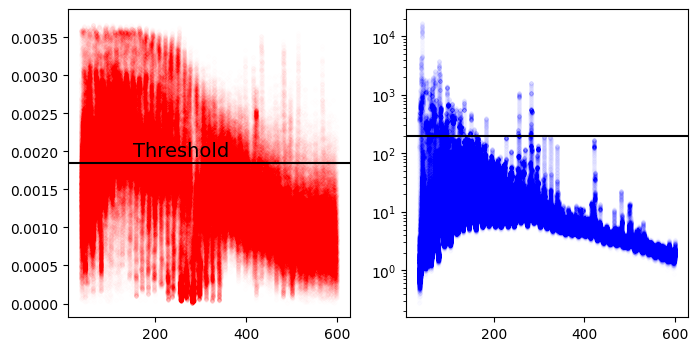

In [6]:
loadings = np.asarray([ pca.components_.T for pca in models ])
print("loadings: ", loadings.shape)
criterion = np.sqrt(np.sum(np.power(loadings, 2), axis=-1))
print("criterion: ", criterion.shape)
threshold = np.sqrt(0.34e-5)
masks = [ crit > threshold for crit in criterion ] # 0.34e-5 for flesh
print(criterion.shape)
import matplotlib.pyplot as plt
fig, (ax,ax2) = plt.subplots(1,2, figsize=(8,4))
ax.plot(M, criterion[1], 'r.', alpha=0.002, label="Norm of first two PCs")
ax2.semilogy(M, X_us.mean(axis=0), 'b.', alpha=0.002, label="Norm of first two PCs")
ax2.axhline(200, color='k')
ax.axhline(threshold, color="k")
ax.text(150, threshold+0.05*threshold, "Threshold", fontdict={"fontsize": 14})
#plt.legend()
#print(loadings[0].shape)

15.19066937767124 % conservation


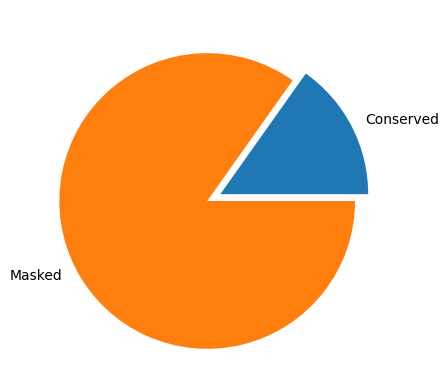

In [7]:
mask = np.logical_not(np.logical_or(np.logical_or(masks[0], masks[1]), masks[2]))
nonzero = np.count_nonzero(mask)
plt.pie([nonzero, len(mask)-nonzero], explode=[0.0, .1], labels=["Conserved", "Masked"])
print(np.count_nonzero(mask) / len(mask)*100, "% conservation")

In [8]:
Xs = X[:,  mask == True]
model = PCA(n_components=Xs.shape[0], whiten=True)
Xs = scaler.fit_transform(Xs)
Xembed = model.fit_transform(Xs)[:,:2]

model_raw =  PCA(n_components=Xs.shape[0], whiten=True)
Xraw = scaler.fit_transform(X)
Xembed_raw = model_raw.fit_transform(Xraw)[:,:2]

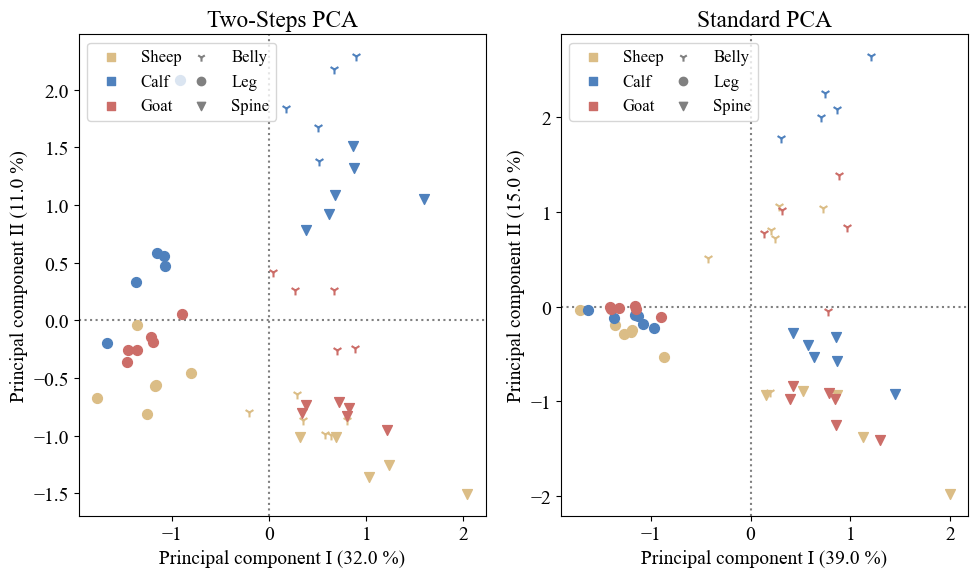

In [9]:
import matplotlib.pyplot as plt
expl_ratio = np.stack([ 
    model.explained_variance_ratio_ / np.sum(model.explained_variance_ratio_),
    model_raw.explained_variance_ratio_ / np.sum(model_raw.explained_variance_ratio_)
])
locations_fancy = ["Belly", "Leg", "Spine"]

def zerocross(ax, color, ls):
    ax.axhline(0, color=color, ls=ls, zorder=0)
    ax.axvline(0, color=color, ls=ls, zorder=0)
plt.rcParams.update({'font.size': 14})
plt.rcParams["font.family"] = "Times New Roman"
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
colorsi = ["#DBBD86", "#4F81BD", "#CC6D68"]
markers = ["1", "o", "v", "^"]
locs = np.asarray(locs)
for ax in (ax1, ax2):
    zerocross(ax, color="grey", ls=":")
legend_lines = [ ax1.scatter([],[], c=colorsi[i], marker="s") for i in range(3)]
legend_lines.extend([ ax1.scatter([],[], c="grey", marker=markers[i]) for i in range(3)])
for i in range(3):
    for j, l in enumerate(locations):
        msk = np.logical_and(species==i, locs==j)
        ax1.scatter(*Xembed[msk,:].T, c=colorsi[i], label=labels[i]+" "+l, marker=markers[j], s=50)
        ax2.scatter(*Xembed_raw[msk,:].T, c=colorsi[i], label=labels[i]+" "+l, marker=markers[j], s=50)
ax1.legend(legend_lines, ["Sheep", "Calf", "Goat", *locations_fancy], ncols=2, loc="upper left", fontsize=12, columnspacing=0.2)

for i, ax in enumerate([ax1, ax2]):
    ax.set_xlabel(f"Principal component I ({100*round(expl_ratio[i, 0], 2)} %)")
    ax.set_ylabel(f"Principal component II ({100*round(expl_ratio[i, 1], 2)} %)")

ax2.legend(legend_lines, ["Sheep", "Calf", "Goat", *locations_fancy], ncols=2, loc="upper left", fontsize=12, columnspacing=0.2)
ax1.set_title("Two-Steps PCA")
ax2.set_title("Standard PCA")


plt.tight_layout()
plt.savefig(f"Results{('Grain', 'Flesh')[flesh]}{polarity}.pdf")

NameError: name 'model2' is not defined

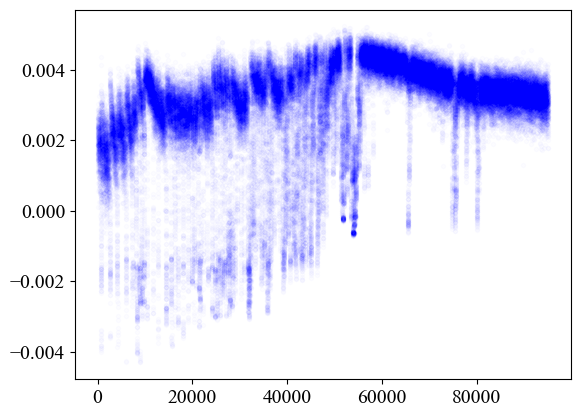

In [10]:
plt.plot(model.components_[0], 'b.', alpha=0.01)
plt.plot(model2.components_[0], 'r.', alpha=0.01)

(2, 74869)


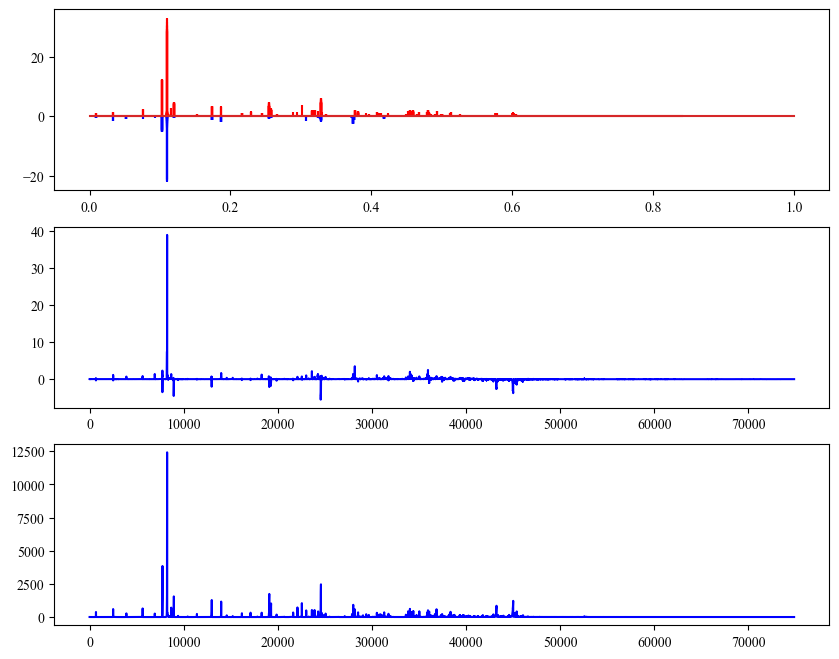

In [19]:
Xm = X_us[:,mask].mean(axis=0)
print(model.components_.shape)
fig, axs = plt.subplots(3,1, figsize=(10, 8))
mask2 = model.components_[0] < 0.0
nmask2 = np.logical_not(mask2)
x = np.linspace(0, 1, len(Xm))
y = model.components_[0, mask2]*Xm[mask2]
y[np.abs(y)< 0.1] = np.nan
axs[0].stem(x[mask2], y, 'b-', markerfmt="none")
y = model.components_[0, nmask2]*Xm[nmask2]
y[np.abs(y)< 0.1] = np.nan

axs[0].stem(x[nmask2], y, 'r-', markerfmt="none")
axs[1].plot((model.components_[1]*Xm), 'b-')
axs[2].plot((Xm[Xm>0]), 'b-')

<StemContainer object of 3 artists>

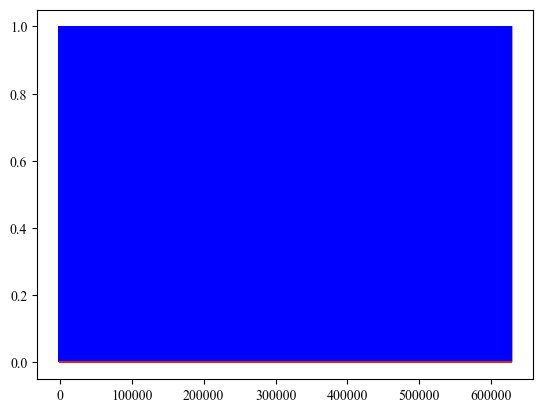

In [27]:
plt.stem(mask, 'b-',markerfmt="none")

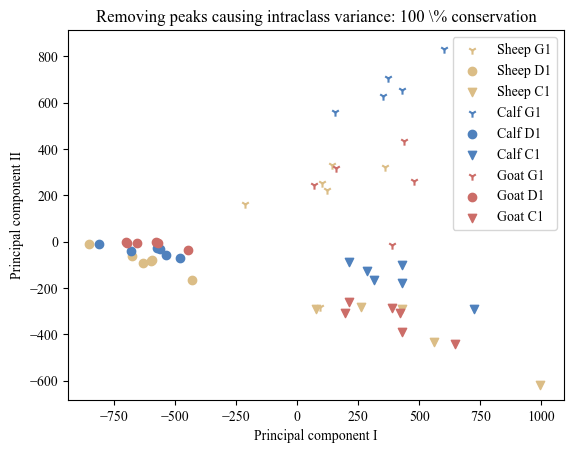

In [187]:
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots()

graphs = []
for i in range(3):
        for j, l in enumerate(locations):
            mask = np.logical_and(species==i, locs==j)
            graphs.append(ax.scatter(*Xembed[mask].T, c=colorsi[i], label=labels[i]+" "+l, marker=markers[j]))


ax.set_xlabel("Principal component I")
ax.set_ylabel("Principal component II")
ax.legend()
ax.set_title(f"Removing peaks causing intraclass variance: {100} \% conservation")

nframes = 100
factors = list(reversed(np.linspace(0.9, 1.5, nframes//4)))
factors.extend(list(reversed(np.linspace(0.32, 0.9, 3*nframes//4))))
ax.set_xlim(-800, 1000)
ax.set_ylim(-600, 1000)
axis_scale = (np.ones(nframes//2)*1500).tolist()
axis_scale.extend(list(reversed(np.linspace(500, 1500, nframes//2))))
def update(frame):
    if frame >= nframes:
        return graphs
    factor = factors[frame]
    loadings = [ pca.components_.T for pca in models ]
    masks = [ np.sum(np.power(l, 2), axis=-1) > factor * 1e-5 for l in loadings ] # 0.34e-5 for flesh
    mask = np.logical_not(np.logical_or(np.logical_or(masks[0], masks[1]), masks[2]))
    conservation = np.count_nonzero(mask) / len(mask)*100
    ax.set_title(f"Removing peaks causing intraclass variance: {round(conservation)} \% conservation")

    Xs = X[:,  mask == True]
    model = PCA(n_components=2)
    Xs = scaler.fit_transform(Xs)
    Xembed = model.fit_transform(Xs)

    colorsi = ["#DBBD86", "#4F81BD", "#CC6D68"]
    markers = ["1", "o", "v", "^"]
    #locs = np.asarray(locs)
    graphsit = iter(graphs)
    for i in range(3):
        for j, l in enumerate(locations):
            mask = np.logical_and(species==i, locs==j)
            next(graphsit).set_offsets(Xembed[mask])
    s = axis_scale[frame]
    ax.set_xlim(Xembed[:, 0].min()*1.1, Xembed[:, 0].max()*1.1)
    ax.set_ylim(Xembed[:, 1].min()*1.1, Xembed[:, 1].max()*1.1)
    ax.legend()
    return graphs
anim = FuncAnimation(fig, update, frames=nframes+20, interval=100, blit=True)
#update(0)
    

In [188]:
anim.save("./test.gif")

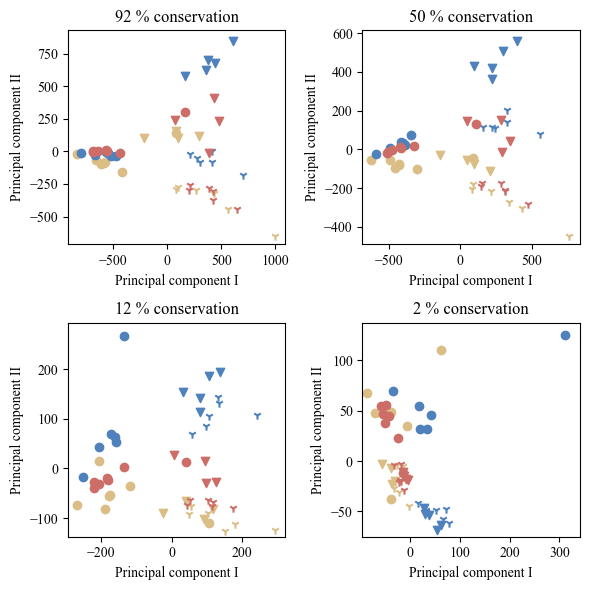

In [21]:
from matplotlib.animation import FuncAnimation
fig, axs = plt.subplots(2,2, figsize=(6,6))

def plotpca(ax, factor):
    loadings = [ pca.components_.T for pca in models ]
    masks = [ np.sum(np.power(l, 2), axis=-1) > factor * 1e-5 for l in loadings ] # 0.34e-5 for flesh
    mask = np.logical_not(np.logical_or(np.logical_or(masks[0], masks[1]), masks[2]))
    conservation = np.count_nonzero(mask) / len(mask)*100

    Xs = X[:,  mask == True]
    model = PCA(n_components=2)
    Xs = scaler.fit_transform(Xs)
    Xembed = model.fit_transform(Xs)

    colorsi = ["#DBBD86", "#4F81BD", "#CC6D68"]
    markers = ["1", "o", "v", "^"]
    #locs = np.asarray(locs)
    for i in range(3):
        for j, l in enumerate(locations):
            mask = np.logical_and(species==i, locs==j)
            ax.scatter(*Xembed[mask].T, c=colorsi[i], label=labels[i]+" "+l, marker=markers[j])
    ax.set_xlim(Xembed[:, 0].min()*1.1, Xembed[:, 0].max()*1.1)
    ax.set_ylim(Xembed[:, 1].min()*1.1, Xembed[:, 1].max()*1.1)
    #ax.legend()
    ax.set_xlabel("Principal component I")
    ax.set_ylabel("Principal component II")
    ax.set_title(f"{round(conservation)} % conservation")


plotpca(axs.flatten()[0], 1.0)
plotpca(axs.flatten()[1], 0.5)
plotpca(axs.flatten()[2], 0.32)
plotpca(axs.flatten()[3], 0.2)
plt.tight_layout()
plt.savefig("ThresholdInfluence.pdf")

In [143]:
X_us.shape

(51, 622539)

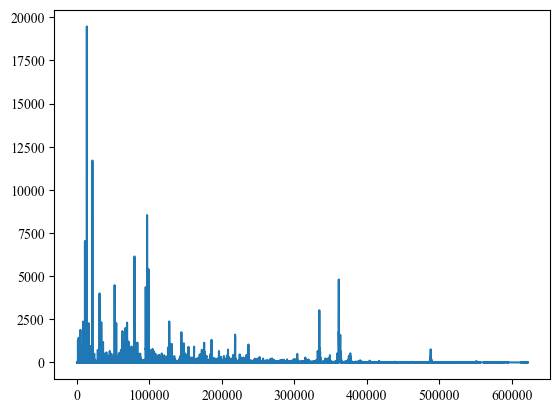

In [144]:
plt.plot(X_us[0])

X.shape (51, 626582)
X_single.shape (16, 626582)


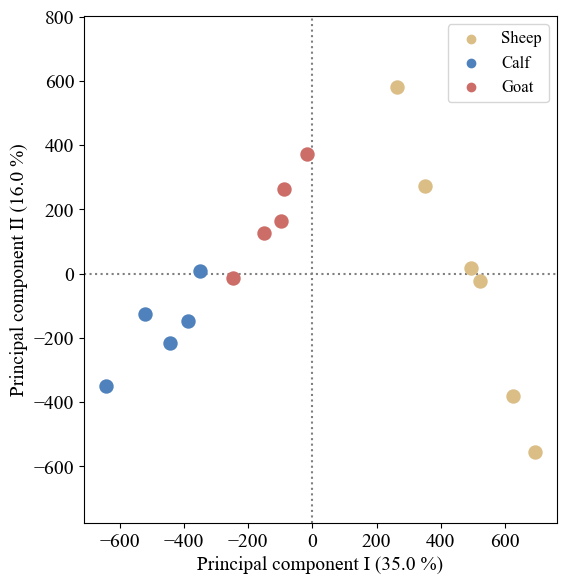

In [64]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plt.rcParams["font.family"] = "Times New Roman"

sel = 0
model = PCA()
print("X.shape", X.shape)
X_single = X[locs==sel]
print("X_single.shape", X_single.shape)
X_single_embed = model.fit_transform(X_single)
expl_ratio = np.stack([model.explained_variance_ratio_ / np.sum(model.explained_variance_ratio_)])

locations_fancy = ["Belly", "Leg", "Spine"]

def zerocross(ax, color, ls):
    ax.axhline(0, color=color, ls=ls, zorder=0)
    ax.axvline(0, color=color, ls=ls, zorder=0)

fig, (ax1) = plt.subplots(1, 1, figsize=(6,6))
colorsi = ["#DBBD86", "#4F81BD", "#CC6D68"]
markers = ["1", "o", "v", "^"]
locs = np.asarray(locs)
for ax in (ax1, ax2):
    zerocross(ax, color="grey", ls=":")
legend_lines = [ ax1.scatter([],[], c=colorsi[i], marker="o") for i in range(3)]
for i in range(3):
    msk = (species==i)[locs==sel]
    ax1.scatter(*X_single_embed[msk,0:2].T, c=colorsi[i], label=labels[i]+" "+l, marker="o", s=70,linewidths=2)
ax1.legend(legend_lines, ["Sheep", "Calf", "Goat", *locations_fancy], fontsize=12, columnspacing=0.2)

for i, ax in enumerate([ax1]):
    ax.set_xlabel(f"Principal component I ({100*round(expl_ratio[i, 0], 2)} %)")
    ax.set_ylabel(f"Principal component II ({100*round(expl_ratio[i, 1], 2)} %)")
plt.axis("equal")
plt.tight_layout()
plt.savefig(f"BellyResults{('Grain', 'Flesh')[flesh]}{polarity}.pdf")